In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

sns.set()

*Надеюсь, случайные значения сильно не скакнут при генерации и мои выводы останутся справедливы)*

In [2]:
np.random.seed(666)

### Расчёт p-value

Чтобы дальше не обращаться несколько раз к проблеме право/лево/двусторонней гипотезы, введу функцию для расчёта p-value по известному z-score. Регион в аргументе соответствует критической области гипотезы.

In [3]:
# region = critical region responding H1

def p_value(zscore, region='two-sided'):
    
    # sf ~ функция выживания = 1 - функция распределения

    if region == 'two-sided':
        pvalue = stats.norm.sf(np.abs(zscore)) * 2
    elif region == 'left':
        pvalue = stats.norm.sf(np.abs(zscore))
    elif region == 'right':
        pvalue = stats.norm.cdf(zscore)
    else:
        print('Беды с критической областью')
    
    return pvalue

### Парный Z-тест для средних

Совершенно не отличается от t-теста Стьюдента, за исключением предположения о знании дисперсий в выборках.

В прикладных задачах мы, конечно, не располагаем информацией о типе и параметрах распределений данных, будем оценивать обычным способом.

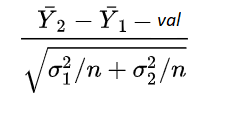

Дисперсии заменим выборочными аналогами, val - предполагаемая разница средних.

--------

Итак, предположим мы анализируем данные о средней прибыли с клиента до и после введения спецпредложения. Повезло, данные распределены нормально)

Руководство знает, что ранее средняя прибыль составляла 400 и расчитывает на обязательный прирост на 10% (уж больно классную акцию они придумали). Переводим на язык статистики -- возросла ли средняя прибыль на val=40 ?

In [4]:
a = np.random.normal(400, 60, 1300)
b = np.random.normal(450, 80, 1000)

val = 40

(<matplotlib.axes._subplots.AxesSubplot at 0x25c78ccb320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25c78ccb320>)

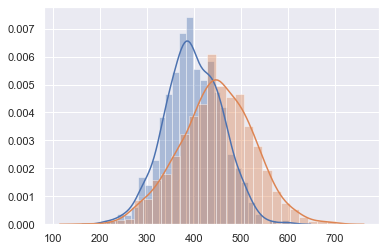

In [5]:
sns.distplot(a, hist = True), sns.distplot(b, hist = True)

In [6]:
def z_score_pair(data_a, data_b, diff):
    n_a, n_b = len(data_a), len(data_b)
    var_a = np.var(data_a, ddof = 1)
    var_b = np.var(data_b, ddof = 1)
    se = np.sqrt(var_a / n_a + var_b / n_b)
    return (data_b.mean() - data_a.mean() - diff) / se

In [7]:
z = z_score_pair(a, b, 40)
print('z_score = ', z)

z_score =  3.146845253261701


In [8]:
p_value(z)

0.0016504228427385642

Для левосторонней критической области гипотезы принимают вид

    H1: средняя прибыль во второй выборке значимо меньше, чем прибыль в первой выборке + val
    H0: средняя прибыль во второй выборке значимо НЕ меньше, чем прибыль в первой выборке + val
    
---------------

Для правосторонней критической области гипотезы принимают вид

    H1: средняя прибыль во второй выборке значимо больше, чем прибыль в первой выборке + val
    H0: средняя прибыль во второй выборке значимо НЕ больше, чем прибыль в первой выборке + val

In [9]:
p_value(z, region='left')

0.0008252114213692821

In [10]:
p_value(z, region='right')

0.9991747885786307

Для уровня значимости `0.01` можем отвергать гипотезы о  строгом равенстве разницы средних значению 40, и о том, что прирост составил менее 40.

Не отвергаем (правостороннюю) гипотезу о приросте прибыли более, чем на 10%, можем идти радовать маркетологов)

----------

Сравним с реализацией из statsmodels:

In [11]:
data = CompareMeans(DescrStatsW(b), DescrStatsW(a))

data.ztest_ind(value=40, usevar='unequal'), \
data.ztest_ind(alternative='larger', value=40, usevar='unequal'), \
data.ztest_ind(alternative='smaller', value=40, usevar='unequal')

((3.1468452532617013, 0.0016504228427385605),
 (3.1468452532617013, 0.0008252114213692802),
 (3.1468452532617013, 0.9991747885786307))

Получили те же z-score и p-value, всё ОК)

### Z-критерий для пропорций

Имеем 2 независимые выборки, элементом является 1 или 0 (успех или неудача). Z-критерий позволяет оценить, равно ли пропорционально число успехов в первой выборке числу успехов во второй.

    H0: пропорции одинаковы
    H1: пропорции различны

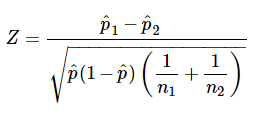

p1, p2 - доля успехов в 1 и 2 выборке соответственно, p - общая доля успехов

----------------------------------------------------------------------------

Пусть данные для исследования - доля активных покупателей, оставивших отзыв до и после введения какого-нибудь классного спецпредложения...
Посмотрим, повлияла ли акционная программа на активность клиентов.

Допустим, наши данные загружены в массивы)

    1 - отзыв оставлен
    0 - клиент бяка)

In [12]:
# изначально мы это не знаем)
n_a, n_a_success = 713, 202
n_b, n_b_success = 505, 169

In [13]:
comments_a = np.random.permutation([1] * n_a_success + [0] * (n_a - n_a_success))
comments_b = np.random.permutation([1] * n_b_success + [0] * (n_b - n_b_success))

*Замечание:*

Z-критерий для пропорций в таком виде не приведён в библиотеках типа scipy, statsmodels, что странно, но это совершенно не проблема, значение вычисляется элементарно:

In [14]:
def z_score_proportion(data_a, data_b):
    n_a = len(data_a)
    n_b = len(data_b)
    n_a_success = data_a.sum()
    n_b_success = data_b.sum()

    p_a = n_a_success / n_a
    p_b = n_b_success / n_b
    p = (n_a_success + n_b_success) / (n_a + n_b)

    return (p_b - p_a) / np.sqrt(p * (1-p) * (1/n_a + 1/n_b))

In [15]:
z = z_score_proportion(comments_a, comments_b)

In [16]:
# двусторонняя гипотеза
p_value(z)

0.05509848585290159

Для левосторонней критической области гипотезы принимают вид

    H1: среднее число успехов во второй группе значимо меньше, чем в первой
    H0: среднее число успехов во второй группе значимо НЕ меньше, чем в первой
    
---------------

Для правосторонней критической области гипотезы принимают вид

    H1: среднее число успехов во второй группе значимо больше, чем в первой
    H0: среднее число успехов во второй группе значимо НЕ больше, чем в первой

In [17]:
p_value(z, region='left')

0.027549242926450796

In [18]:
p_value(z, region='right')

0.9724507570735492

Таким образом, выбирая уровень значимости `0.05` мы отвергаем левостороннюю гипотезу и НЕ отвергаем правостороннюю. Это совершенно согласуется с реальностью, так как доля успехов во второй выборке побольше, чем в первой.

При том же уровне значимости мы также НЕ отвергаем гипотезу о равенстве среднего числа отзывов в двух группах ¯\\_(ツ)_/¯. Однако, выбрав уровень значимости, например, `0.1`, мы уже можем отвергать двустороннюю гипотезу     


**Вывод:** играемся с уровнем значимости как хотим и делаем удобные для нас выводы))